In [1]:
import importlib
import tidy_data
importlib.reload(tidy_data)
from tidy_data import profile_stats, process_skills, get_long_jobs
import pandas as pd
pd.set_option('display.max_rows', 500)
import datetime
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import collections
%matplotlib inline
from scipy import stats

## Get and process data

In [2]:
### Load data from quotacom. Includes LinkedIn url and type (contact|candidate)
qc_data = pd.read_csv('../quotacom/data/processed/all_data.csv')
qc_data = qc_data[(qc_data.linkedin.notna()) & (qc_data.firstName.notna())].drop_duplicates('id')


/Users/lsprejer/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
with open('data/raw/scraped_profiles_clean.json') as json_data:
    profiles = json_data.readlines()
    
profiles_df = profile_stats(profiles)
profiles_df = profiles_df.merge(qc_data[['id','linkedin', 'type']], on='id',how='left')

# Names to gender based on genderise + manual checks for those with p < 0.8.
names_to_gender = pd.read_csv('methodology/data/processed/names_to_gender.csv')

profiles_df = profiles_df.merge(names_to_gender[['id','gender_recat']],how='left',on='id')

### Remove duplicated names
profiles_df.drop_duplicates(['name','linkedin'], inplace=True); len(profiles_df)
print('Number of profiles: ',len(profiles_df))

### Remove people with unidentified gender
profiles_df = profiles_df[(profiles_df.gender != "") & ~(profiles_df.gender.isna())]

Number of profiles:  21002


In [4]:
### Add location to profiles
id_to_loc = pd.read_csv('methodology/data/processed/id_to_loc.csv')

profiles_df = profiles_df.merge(id_to_loc, on='id',how='left')
profiles_df.loc[profiles_df.location.notna(),'location2'] = profiles_df[profiles_df.location.notna()]['location'].apply(lambda x: x if x in ["United kingdom",'United states','France','Germany'] else 'Others')


In [5]:
### Get long df with all jobs by id
jobs_df = get_long_jobs(profiles)
jobs_df = jobs_df.merge(profiles_df[['id','gender_recat']].drop_duplicates('id'), on ='id', how='left')

### Match companies to industry group
company_to_industry_group = pd.read_csv('methodology/data/processed/industry_df.csv')
jobs_df = jobs_df.merge(company_to_industry_group[['company','industry_group']], on='company',how='left')

### Match industry to industry group
industry_to_group = jobs_df[jobs_df.industry_group.isna()].drop('industry_group',axis=1).merge(company_to_industry_group[['industry','industry_group']].drop_duplicates('industry'), on='industry',how='left')
jobs_df = pd.concat([jobs_df[jobs_df.industry_group.notna()], industry_to_group])

jobs_df = jobs_df[jobs_df.id.isin(profiles_df.id.values)]

In [6]:
jobs_df['start_date'] = jobs_df.start_date.apply(lambda x: pd.to_datetime(x))
jobs_df['end_date'] = jobs_df.end_date.apply(lambda x: pd.to_datetime(x))


In [7]:
### Compute stats on job duration, number of roles, etc.
jobs_summary = jobs_df.groupby('id').agg(
    min_date = pd.NamedAgg(column='start_date', aggfunc='min'),
    max_date = pd.NamedAgg(column='end_date', aggfunc='max'),
    n_roles = pd.NamedAgg(column='role', aggfunc='count'),
    n_companies = pd.NamedAgg(column='company', aggfunc='nunique'),
    n_industries = pd.NamedAgg(column='industry', aggfunc='nunique'),
    av_role_duration = pd.NamedAgg(column='duration', aggfunc='mean'))

jobs_summary['years_of_experience'] = ((jobs_summary.max_date - jobs_summary.min_date)/np.timedelta64(1, 'Y')).values

av_duration_company = jobs_df.groupby(['id','company']).duration.mean().reset_index().groupby('id').duration.mean().reset_index()
av_duration_company.columns = ['id','av_duration_company']

jobs_summary = jobs_summary.merge(av_duration_company, on = 'id', how='left')
jobs_summary['av_duration_company'] /= 12
jobs_summary['av_role_duration'] /= 12

In [8]:
### For each id compute years of experience without breaks and overlapping jobs. 

id_list = []
years_experience_list = []
for group, df in jobs_df.groupby('id'):
    id_list.append(group)
    years_of_experience = 0
    for idx, row in df.sort_values(by='start_date').iterrows():
        if years_of_experience == 0:
            max_date = row['end_date']
            years_of_experience = max_date - row['start_date']
        else:
            this_min = row['start_date']
            this_max = row['end_date']
            if this_max <= max_date:
                continue
            elif this_min <= max_date:
                years_of_experience += this_max - max_date
                max_date = this_max
            else:
                years_of_experience += this_max - this_min
                max_date = this_max

    years_of_experience /= np.timedelta64(1, 'Y')
    years_experience_list.append(years_of_experience)
years_experience_df = pd.DataFrame({'id':id_list, "total_experience":years_experience_list})

In [9]:
profiles_df = profiles_df.merge(years_experience_df, on = 'id', how='left')
profiles_df = profiles_df.merge(jobs_summary.drop_duplicates('id'), on='id',how='left')
profiles_df = profiles_df.merge(qc_data[['id','type']].drop_duplicates('id'), on='id',how='left')

In [10]:
### Remove profiles with zero work experience / no work posted
profiles_df = profiles_df[~profiles_df.years_of_experience.isna()]

In [11]:
jobs_df = jobs_df[jobs_df.id.isin(profiles_df.id.values)]
jobs_df = jobs_df.merge(profiles_df[['id','location','location2']],on='id',how='left')

In [12]:
jobs_seniority = pd.read_csv('methodology/data/processed/jobs.csv')
jobs_df = jobs_df.merge(jobs_seniority[['id','role','company','duration','seniority','role_clean','seniority2','seg']],how='left',on=['id','role','company','duration'])

In [13]:
educ = pd.read_csv('methodology/data/processed/educ_df.csv')
educ = educ[educ.id.isin(profiles_df.id.values)]
educ['max_degree2'] = educ.max_degree.apply(lambda x: x if x in ['not university', 'bachelor'] else 'post graduate')
educ = educ.merge(profiles_df[['id','gender_recat','location2']], on='id', how='left')

In [14]:
educ_industry = educ.merge(jobs_df[['id','industry_group']],on='id',how='left')

In [15]:
skills_df = process_skills(profiles)
skills_df = skills_df.merge(profiles_df[['id','gender_recat','location2']].drop_duplicates('id'), on ='id', how='left')
skills_df = skills_df[skills_df.id.isin(profiles_df.id.values)]

In [16]:
skills_long = pd.read_csv('methodology/data/processed/skills_long.csv')
skills_long = skills_long[skills_long.id.isin(profiles_df.id.values)]
skills_long = skills_long.merge(profiles_df, on='id',how='left')
skills_long = skills_long[skills_long.gender_recat.notna()]; len(skills_long)

494582

In [17]:
skills_long['recat2'] = skills_long.recat.apply(lambda x: x if x in ['industry_knowledge','interp_skills','other','languages'] else 'Data science and AI')


## EDA

Key points: 
- 11% of data are Female
- 52% based on the US, France, Germany and the UK
- Very mature data:
    - Median of 20 years of experience in the job market
    - Median of 7 different roles in 5 different companies in 3 different industries
    - Median of 3 years in each role
- Predominance of Information and Communication Technology industry


In [19]:
len(profiles_df)

19560

In [20]:
print('Percentage of gender in collected profiles: \n')
print(profiles_df.gender_recat.value_counts(normalize=True))
print('')
print(profiles_df.gender_recat.value_counts())

Percentage of gender in collected profiles: 

male      0.887321
female    0.112679
Name: gender_recat, dtype: float64

male      17356
female     2204
Name: gender_recat, dtype: int64


<AxesSubplot:title={'center':'Gender'}, ylabel='gender_recat'>

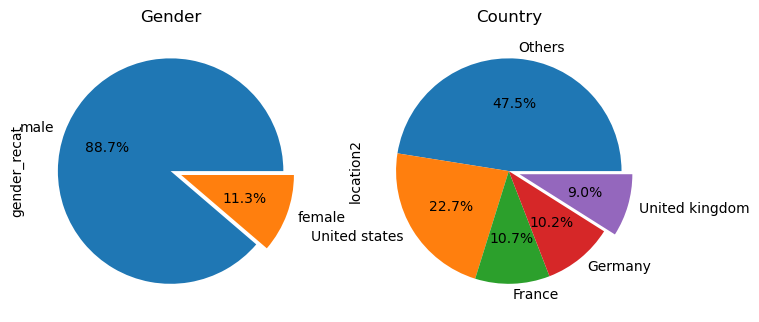

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), dpi= 100,)

explode = [0,0,0,0,0.1]
(profiles_df.location2.value_counts().
 plot.pie(autopct='%1.1f%%', ax=axes[1], title='Country',figsize=(8,6), explode=explode))

explode = [0,0.1]
(profiles_df.gender_recat.value_counts().
 plot.pie(autopct='%1.1f%%', explode=explode, ax=axes[0], title = 'Gender', figsize=(8,6)))

In [22]:
exp_mean = profiles_df.total_experience.describe()['mean']
exp_std = profiles_df.total_experience.describe()['std']
profiles_df = profiles_df[profiles_df.total_experience <= (exp_mean + 3.5*exp_std)]
print('N obs after outliers removal: ', len(profiles_df))

N obs after outliers removal:  19535


In [23]:
profiles_df.total_experience.describe()

count    19535.000000
mean        19.884167
std          7.218207
min          1.002074
25%         14.751843
50%         19.833398
75%         24.420762
max         45.337002
Name: total_experience, dtype: float64

In [24]:
profiles_df[['total_experience','n_roles','n_companies','n_industries','av_role_duration']].describe()

,total_experience,n_roles,n_companies,n_industries,av_role_duration
count,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000
mean,19.884167,7.326286,5.291170,3.638034,3.768523
std,7.218207,2.534984,2.427086,1.714457,3.073034
min,1.002074,1.000000,1.000000,1.000000,0.366667
25%,14.751843,6.000000,4.000000,2.000000,2.257260
50%,19.833398,7.000000,5.000000,3.000000,3.027778
75%,24.420762,9.000000,7.000000,5.000000,4.208333
max,45.337002,17.000000,14.000000,13.000000,40.833333


Percentage of industries identified: 0.1680859353258752


<AxesSubplot:title={'center':'Number of jobs in a company belonging to a particular industry'}>

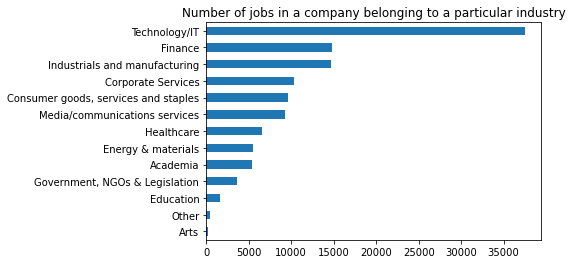

In [25]:
print('Percentage of industries identified:', len(jobs_df[jobs_df.industry_group.isna()]) / len(jobs_df))

(jobs_df.industry_group.value_counts().head(20).
 sort_values(ascending=True).
 plot.barh(title = 'Number of jobs in a company belonging to a particular industry'))

**There's no significant difference in the age of our sample**

<AxesSubplot:title={'center':'Age'}, ylabel='Density'>

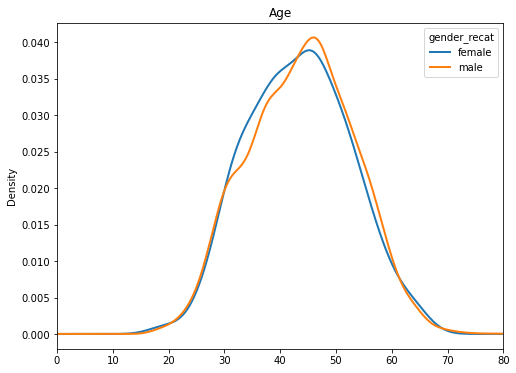

In [26]:
(profiles_df[profiles_df.age > 0].
 pivot(columns='gender_recat',values='age').
 plot.density(figsize=(8,6),linewidth=2, xlim=(0,80), title="Age"))

In [27]:
stats.ttest_ind(profiles_df[profiles_df.gender_recat == 'female'].age.values,
                         profiles_df[profiles_df.gender_recat == 'male'].age.values)

Ttest_indResult(statistic=-0.09966006779029321, pvalue=0.9206152266802863)

# 1) Industry differences

In [28]:
CXO = ['CXO','director','head','principal']
Board = ['founder','board','partner','president','chairman','vp','owner']
jobs_df.loc[jobs_df.seniority.isin(CXO),'seniority3'] = 'CXO'
jobs_df.loc[jobs_df.seniority.isin(Board),'seniority3'] = 'Board'
jobs_df.loc[jobs_df.seniority3.isna(),'seniority3'] = jobs_df.loc[jobs_df.seniority3.isna(),'seniority2']


In [29]:
max_degree = educ.drop_duplicates(['id','max_degree'])
max_degree_industry = educ_industry.drop_duplicates(['id','max_degree'])

In [30]:
last_role = jobs_df.sort_values(by=['id','start_date']).drop_duplicates('id',keep='last')
last_role = last_role.merge(educ[['id','max_degree','max_degree2','CAH1','years_education']].drop_duplicates('id'), on='id',how='left')

In [31]:
# Sample
# last_role[last_role.seniority3.notna()].drop_duplicates(['id','company']).groupby('industry_group').gender_recat.value_counts()

sample_ind = ['Consumer goods, services and staples','Corporate Services','Finance','Healthcare',\
             'Industrials and manufacturing', 'Media/communications services','Technology/IT']

### i **Women are overrepresented in industries with less tools&tech skills**

In [32]:
skills_industry = skills_df.merge(jobs_df[['id','industry_group']].drop_duplicates(),on='id',how='left')

In [33]:
companies = jobs_df.drop_duplicates(['id','company']); #print(len(industry_df))
top_20_industries = companies.industry_group.value_counts().head(20).reset_index()['index'].values
sorterIndex = dict(zip(top_20_industries, range(len(top_20_industries))))
companies['Rank'] = companies['industry_group'].map(sorterIndex)
p_female = profiles_df.gender_recat.value_counts(normalize=True).female

<ipython-input-33-144adda4ba1d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies['Rank'] = companies['industry_group'].map(sorterIndex)


In [34]:
profiles_df.gender_recat.value_counts(normalize=True)

male      0.887228
female    0.112772
Name: gender_recat, dtype: float64

In [35]:
profiles_df[profiles_df.n_skills == 0].gender_recat.value_counts() / profiles_df.gender_recat.value_counts()

male      0.059832
female    0.063096
Name: gender_recat, dtype: float64

In [36]:
p_female

0.11277194778602509

<AxesSubplot:title={'center':'Number of profiles who have held at least one job by industry'}>

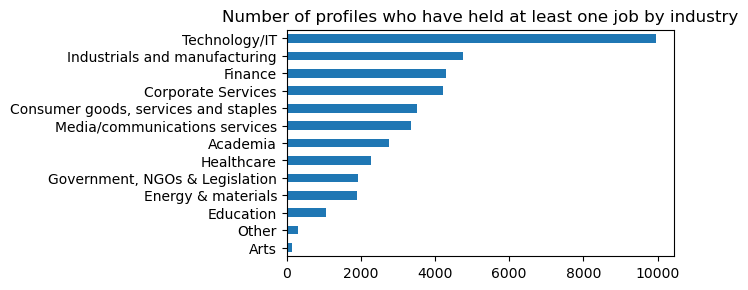

In [37]:
fig, axes = plt.subplots(figsize=(5,3), dpi= 100,)
skills_industry.drop_duplicates(['id','industry_group']).industry_group.value_counts().sort_values(ascending=True).plot.barh(title='Number of profiles who have held at least one job by industry')


In [38]:
skills_industry.drop_duplicates(['id','industry_group']).industry_group.value_counts()

Technology/IT                           9952
Industrials and manufacturing           4749
Finance                                 4291
Corporate Services                      4218
Consumer goods, services and staples    3513
Media/communications services           3358
Academia                                2752
Healthcare                              2268
Government, NGOs & Legislation          1932
Energy & materials                      1902
Education                               1048
Other                                    297
Arts                                     149
Name: industry_group, dtype: int64

[[Text(0, 0, ''),
  Text(0, 1, ''),
  Text(0, 2, ''),
  Text(0, 3, ''),
  Text(0, 4, ''),
  Text(0, 5, ''),
  Text(0, 6, '')],
 Text(0, 0.5, ''),
 Text(0.5, 0, '%')]

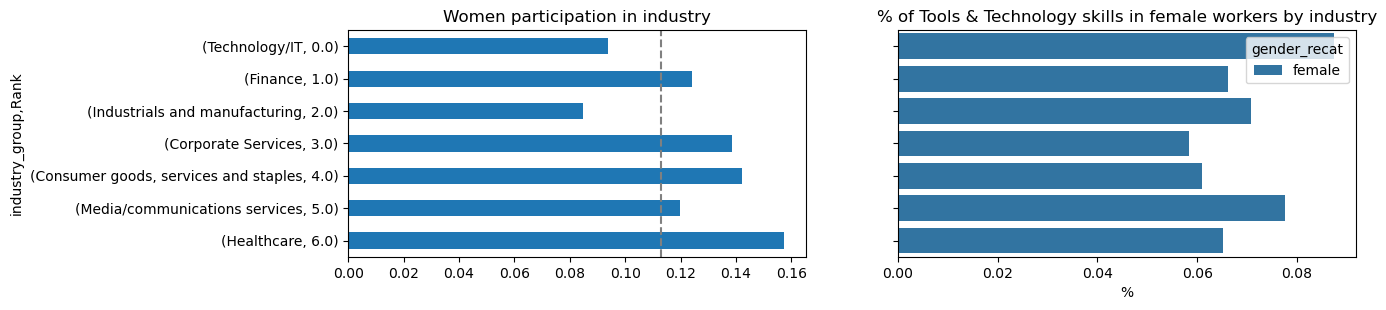

In [39]:
df = (skills_industry.
 melt(id_vars=['industry_group','gender_recat'],
      value_vars=['n_skills_industry','n_skills_tools','n_skills_interp','n_skills_other','n_skills_languages']).
 groupby(['industry_group','variable', 'gender_recat']).
 sum())['value'].reset_index()

totals = df.groupby(['industry_group','gender_recat']).value.sum().reset_index()
totals.rename(columns={'value':'total'},inplace=True)
df = df.merge(totals, on=['industry_group','gender_recat'],how='left')
df = df.merge(companies[['industry_group','Rank']].drop_duplicates(), on='industry_group',how='left')
df['perc'] = df.value/df.total

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,3), dpi= 100,)

(companies[companies.industry_group.isin(sample_ind)].#drop_duplicates(['id','industry_group']).
 groupby(['industry_group','Rank']).
 gender_recat.value_counts(normalize=True).unstack().
 sort_values(by='Rank', ascending=False).drop('male',axis=1).
 plot.barh(legend=None, ax=axes[0]))

axes[0].axvline(x=p_female, color='gray',linestyle='--')

sns.barplot(y = "industry_group",       # x variable name
            x = "perc",       # y variable name
            hue = "gender_recat",  # group variable name
            data = df[(df.variable == 'n_skills_tools') & (df.industry_group.isin(sample_ind)) &\
                      (df.gender_recat == 'female')].sort_values(by='Rank'),
            ax=axes[1])

axes[0].set_title('Women participation in industry')
axes[1].set_title('% of Tools & Technology skills in female workers by industry')
axes[1].set(yticklabels="", ylabel="", xlabel='%')

In [40]:
stats.pearsonr(
    (companies[companies.industry_group.isin(sample_ind)].#drop_duplicates(['id','industry_group']).
 groupby(['industry_group','Rank']).
 gender_recat.value_counts(normalize=True).unstack().
 sort_values(by='Rank', ascending=False))['female'].values,
               df[(df.variable == 'n_skills_tools') & (df.industry_group.isin(sample_ind)) & (df.gender_recat== 'female')].sort_values(by='Rank', ascending=False).perc.values)


(-0.8469263780762432, 0.033353925725733445)

###  ii. There’s little difference in seniority across all of our sample. But the difference is higher for some industries (such as Tech)

**When we look at the seniority distribution, there is not a big gender gap across all industries**

In [42]:
df = last_role.groupby('gender_recat').seniority3.value_counts(normalize=True).reset_index(name='count')
df = df.pivot(index='seniority3',values='count',columns='gender_recat')
df['gap'] = df.female/df.male
df

gender_recat,female,male,gap
seniority3,,,
Board,0.348523,0.343598,1.014332
CXO,0.520280,0.545426,0.953898
Junior,0.002504,0.001661,1.507261
Mid,0.079119,0.060567,1.306293
Senior,0.049574,0.048748,1.016957


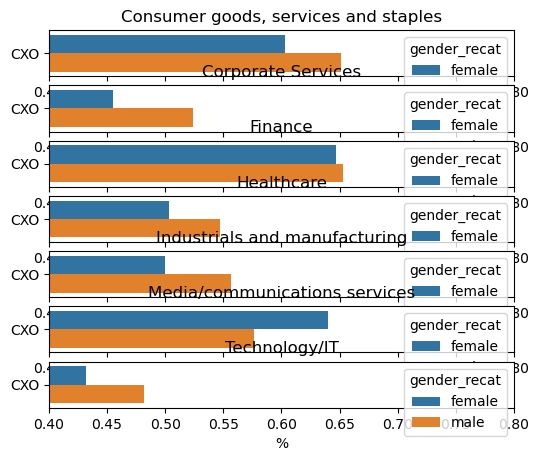

In [43]:
# Only keeping industries with enough sample
df = (last_role[(last_role.industry_group.isin(sample_ind))]
      .groupby(['industry_group','gender_recat'])
      .seniority3.value_counts(normalize=True)
      .reset_index(name='count'))

df = df[df.seniority3 == 'CXO']
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(6,5), dpi= 100,)

for idx, ind in enumerate(df.industry_group.unique()):
    sns.barplot(y = "seniority3",       # x variable name
                x = "count",       # y variable name
                hue = "gender_recat",  # group variable name
                data = df[df.industry_group == ind],
                ax=axes[idx]
               )     # dataframe to plot)
    axes[idx].set_title(ind)
    axes[idx].set(xlim=(0.4, 0.8), ylabel="", xlabel='%')

In [44]:
df = df.pivot(index='industry_group',columns='gender_recat')['count']
df['gap'] = df.female/df.male
df

gender_recat,female,male,gap
industry_group,,,
"Consumer goods, services and staples",0.603015,0.651029,0.926249
Corporate Services,0.455090,0.523724,0.868949
Finance,0.646865,0.653194,0.990311
Healthcare,0.502994,0.546908,0.919704
Industrials and manufacturing,0.500000,0.556295,0.898804
Media/communications services,0.639640,0.576167,1.110163
Technology/IT,0.432258,0.481653,0.897446


### III. Role duration. Women spend less time in roles (have higher turnover rates than men) – notably this is more prominent in the tech industry, than any other industry

[(0.0, 42.0), Text(0.5, 0, 'months'), Text(0, 0.5, '')]

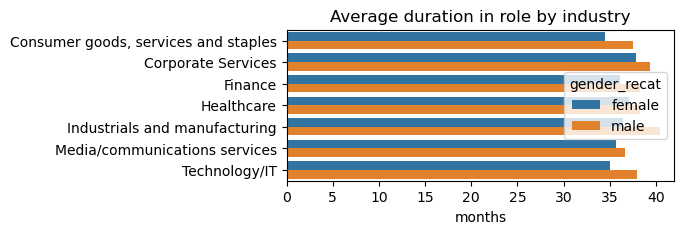

In [45]:
df = jobs_df[jobs_df.industry_group.isin(sample_ind)].groupby(['industry_group','gender_recat']).duration.mean().reset_index()
fig, axes = plt.subplots(figsize=(5,2), dpi= 100,)

sns.barplot(y = "industry_group",       # x variable name
                x = "duration",       # y variable name
                hue = "gender_recat",  # group variable name
                data = df)
axes.set_title('Average duration in role by industry')
axes.set(xlim=(0, 42), xlabel='months', ylabel='')

In [46]:
df = df.pivot(index='industry_group',columns='gender_recat')['duration']
df['gap'] = df.female/df.male
df

gender_recat,female,male,gap
industry_group,,,
"Consumer goods, services and staples",34.470242,37.567584,0.917553
Corporate Services,37.803336,39.389963,0.959720
Finance,36.175127,38.311762,0.944230
Healthcare,37.146872,38.303400,0.969806
Industrials and manufacturing,36.459889,40.491954,0.900423
Media/communications services,35.736292,36.717573,0.973275
Technology/IT,34.990313,37.994162,0.920939


In [47]:
print(stats.ks_2samp(jobs_df[(jobs_df.gender_recat == 'female')].duration,
           jobs_df[(jobs_df.gender_recat == 'male')].duration))
print(stats.ttest_ind(jobs_df[(jobs_df.gender_recat == 'female')].duration,
           jobs_df[(jobs_df.gender_recat == 'male')].duration))

KstestResult(statistic=0.028645481173226628, pvalue=9.610859981292312e-11)
Ttest_indResult(statistic=-7.990590531631831, pvalue=1.3527908656311255e-15)


In [48]:
for ind in jobs_df[jobs_df.industry_group.isin(sample_ind)].industry_group.unique():
    print(ind)
    print(stats.ks_2samp(jobs_df[(jobs_df.industry_group == ind) & (jobs_df.gender_recat == 'female')].duration,
               jobs_df[(jobs_df.industry_group == ind) & (jobs_df.gender_recat == 'male')].duration))
    print(stats.ttest_ind(jobs_df[(jobs_df.industry_group == ind) & (jobs_df.gender_recat == 'female')].duration,
               jobs_df[(jobs_df.industry_group == ind) & (jobs_df.gender_recat == 'male')].duration))
    print("- ")

Healthcare
KstestResult(statistic=0.022600460076965395, pvalue=0.7271842310246401)
Ttest_indResult(statistic=-0.9431349095294409, pvalue=0.3456468841873097)
- 
Media/communications services
KstestResult(statistic=0.016577995783125948, pvalue=0.9399602502149518)
Ttest_indResult(statistic=-0.852235363310096, pvalue=0.39410548235406606)
- 
Technology/IT
KstestResult(statistic=0.032309470145371555, pvalue=0.0021416129873605316)
Ttest_indResult(statistic=-4.458054210829532, pvalue=8.294638597153844e-06)
- 
Consumer goods, services and staples
KstestResult(statistic=0.03871916619573943, pvalue=0.05859287568481841)
Ttest_indResult(statistic=-2.818482100260107, pvalue=0.00483503147600129)
- 
Finance
KstestResult(statistic=0.021144151079113993, pvalue=0.4236602523170119)
Ttest_indResult(statistic=-2.216394492488074, pvalue=0.02667960345057181)
- 
Corporate Services
KstestResult(statistic=0.029094639761592978, pvalue=0.24029839544913)
Ttest_indResult(statistic=-1.388576735032921, pvalue=0.164991

[Text(0.5, 0, 'months'), Text(0, 0.5, '')]

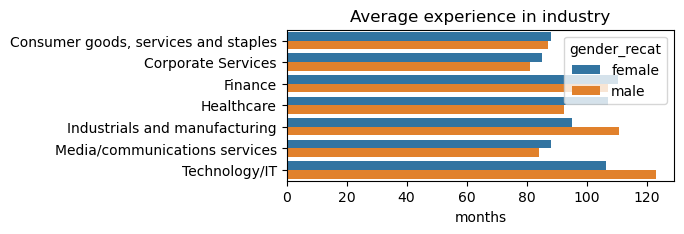

In [49]:
df = jobs_df[jobs_df.industry_group.isin(sample_ind)].groupby(['industry_group','id','gender_recat']).duration.sum().reset_index()
df = df.groupby(['industry_group','gender_recat']).duration.mean().reset_index()

fig, axes = plt.subplots(figsize=(5,2), dpi= 100,)

sns.barplot(y = "industry_group",       # x variable name
                x = "duration",       # y variable name
                hue = "gender_recat",  # group variable name
                data = df)
axes.set_title('Average experience in industry')
axes.set(xlabel='months', ylabel='')

In [50]:
df = df.pivot(index='industry_group',columns='gender_recat')['duration']
df['gap'] = df.female/df.male
df

gender_recat,female,male,gap
industry_group,,,
"Consumer goods, services and staples",88.184211,87.099097,1.012458
Corporate Services,84.998437,81.307280,1.045398
Finance,110.488372,107.183004,1.030839
Healthcare,107.259162,92.626452,1.157976
Industrials and manufacturing,95.037267,110.779250,0.857898
Media/communications services,88.113734,84.308279,1.045137
Technology/IT,106.503791,123.091795,0.865239


# 2) Skills & Job segregation

<AxesSubplot:title={'center':'Data science skills (HDSR categories)'}, ylabel='recat'>

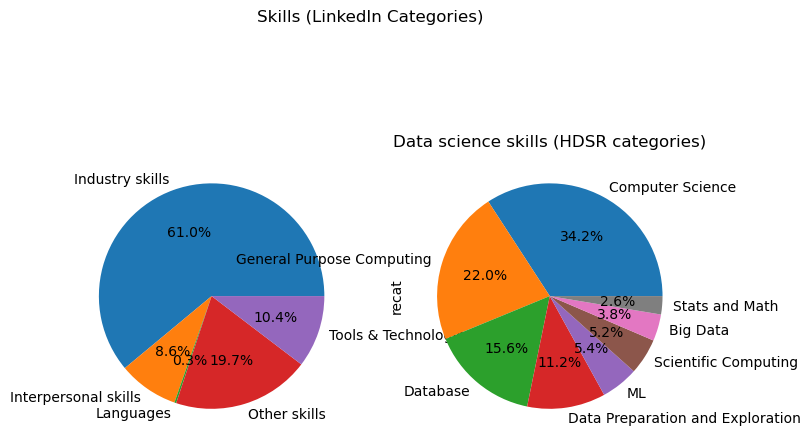

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3), dpi= 100,)

labels = ['Industry skills', 'Interpersonal skills', 'Languages', 'Other skills', 'Tools & Technologies']
(skills_df.
 melt(id_vars='gender_recat',value_vars=['n_skills_industry','n_skills_tools','n_skills_interp','n_skills_other','n_skills_languages']).
 groupby('variable').
 sum().
 unstack().
 plot.pie(subplots=True, labels=labels,
                        autopct='%1.1f%%', 
                        legend=None,ylabel="", title='Skills (LinkedIn Categories)', ax=axes[0]))


(skills_long[~skills_long.recat.isin(['tools_tech','industry_knowledge','interp_skills','other','languages','review'])].recat.value_counts().
 plot.pie(autopct='%1.1f%%', title='Data science skills (HDSR categories)',figsize=(8,6), ax=axes[1]))


In [52]:
# Checking sample
# skills_long[~(skills_long.recat.isin(['industry_knowledge','interp_skills','other','languages','review']))].drop_duplicates(['recat','id']).groupby('recat').gender_recat.value_counts()


In [53]:
# Percentage of men and women with at least one skill in each category
df = skills_long[~(skills_long.recat.isin(['industry_knowledge','interp_skills','other','languages','review','tools_tech']))].drop_duplicates(['recat','id']).groupby('gender_recat').recat.value_counts().reset_index(name='pct').pivot(index='recat',columns='gender_recat',values='pct')
df.female /= sum(skills_long.drop_duplicates('id').gender_recat == 'female')
df.male /= sum(skills_long.drop_duplicates('id').gender_recat == 'male')
df.assign(gender_gap = df.female / df.male)

gender_recat,female,male,gender_gap
recat,,,
Big Data,0.073673,0.128636,0.572723
Computer Science,0.409534,0.560505,0.730652
Data Preparation and Exploration,0.404117,0.353580,1.142928
Database,0.227519,0.296754,0.766693
General Purpose Computing,0.257313,0.405008,0.635329
ML,0.099675,0.130863,0.761673
Scientific Computing,0.156555,0.201930,0.775291
Stats and Math,0.088841,0.077546,1.145651


[Text(0.5, 0, '%'), Text(0, 0.5, 'Data skill')]

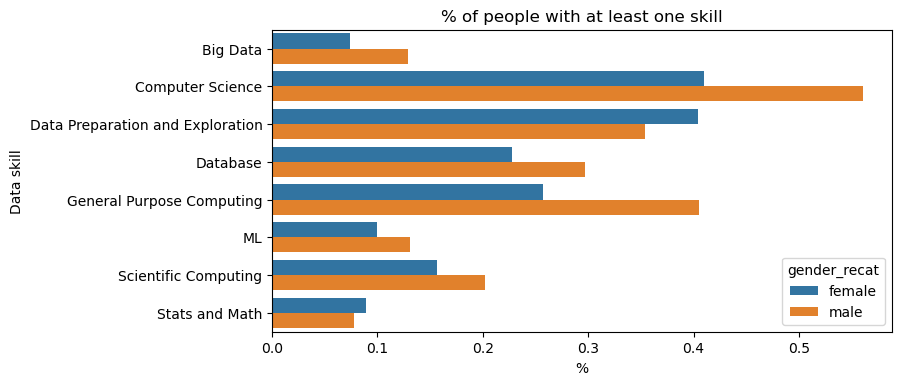

In [54]:
fig, axes = plt.subplots(figsize=(8,4), dpi= 100,)
sns.barplot(y = "recat",       # x variable name
                x = "value",
            hue = 'gender_recat',# group variable name
                data = df.reset_index().melt(id_vars = 'recat'))

axes.set_title('% of people with at least one skill')
axes.set(xlabel='%', ylabel='Data skill')

[Text(0.5, 0, '%'), Text(0, 0.5, 'Field')]

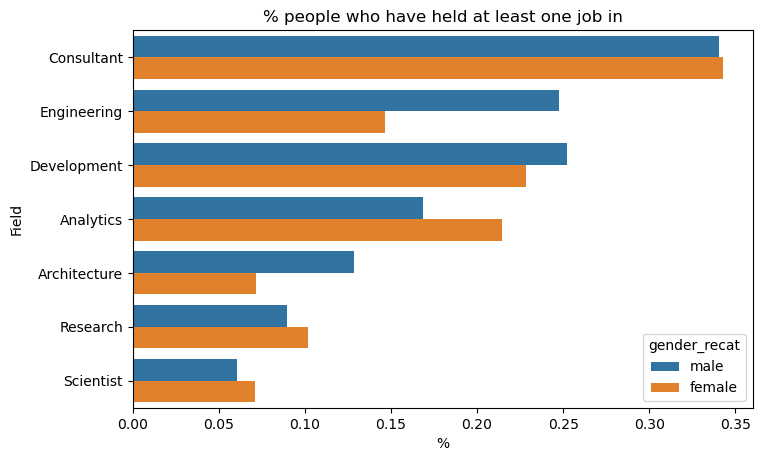

In [57]:
df = jobs_df.seg.value_counts().reset_index()['index'].values
sorterIndex = dict(zip(df, range(len(df))))
jobs_df['Rank'] = jobs_df['seg'].map(sorterIndex)
df = jobs_df.drop_duplicates(['seg','id']).groupby(['seg','Rank']).gender_recat.value_counts().reset_index(name='counts')

not_enough_sample = ['Statistician / Mathematician','Software Designer','Database Engineer','Machine Learning Engineer',\
'Computer Scientist/Eng/Dev/Des','Database Architect','Database Manager','Database Analyst']

df = df[~df.seg.isin(not_enough_sample)]
df.loc[df.gender_recat == 'male', 'counts'] /= jobs_df[jobs_df.gender_recat == 'male'].id.nunique()
df.loc[df.gender_recat == 'female', 'counts'] /= jobs_df[jobs_df.gender_recat == 'female'].id.nunique()
fig, axes = plt.subplots(figsize=(8,5), dpi= 100,)
sns.barplot(y = "seg",       # x variable name
                x = "counts",
            hue = 'gender_recat',# group variable name
                data = df.sort_values(by='Rank'))

axes.set_title('% people who have held at least one job in')
axes.set(xlabel='%', ylabel='Field')


In [58]:
df = df.pivot(index='seg',columns='gender_recat')['counts']
df['gap'] = df.female/df.male
df

gender_recat,female,male,gap
seg1,,,
Analytics,0.214610,0.168818,1.271252
Architecture,0.071688,0.128659,0.557194
Consultant,0.343013,0.340747,1.006650
Development,0.228675,0.252305,0.906345
Engineering,0.146552,0.247465,0.592212
Research,0.101633,0.089825,1.131462
Scientist,0.070780,0.060613,1.167742


# 3. Women report less skills than men

In [60]:
n_skills = profiles_df.groupby('gender_recat').n_skills.value_counts().reset_index(name='n')
n_skills = n_skills.pivot(index='n_skills',values='n',columns='gender_recat').reset_index()
n_skills['female'] /= sum(profiles_df.gender_recat == 'female')
n_skills['male'] /= sum(profiles_df.gender_recat == 'male')

(array([[ 146.,  110.,  188.,  344.,  322.,  264.,  210.,  169.,  146.,
          304.],
        [1076.,  832., 1209., 2030., 2223., 2011., 1656., 1459., 1241.,
         3595.]]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <a list of 2 BarContainer objects>)

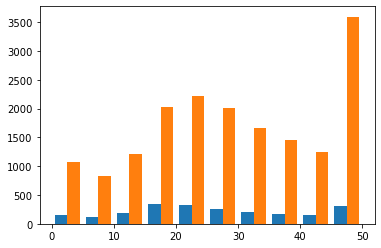

In [61]:
plt.hist(profiles_df.pivot(columns='gender_recat',values='n_skills'))

[Text(0.5, 0, 'Number of skills'), Text(0, 0.5, 'Density')]

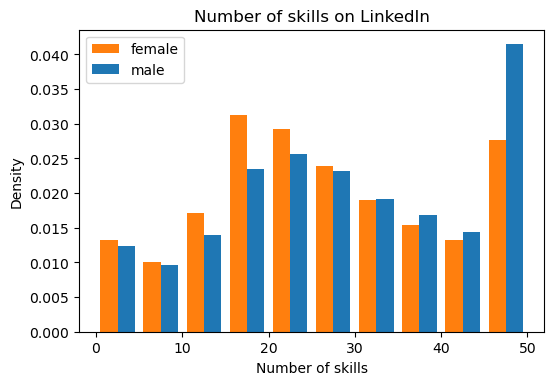

In [62]:
fig, axes = plt.subplots(figsize=(6,4), dpi= 100,)
plt.hist(profiles_df.pivot(columns='gender_recat',values='n_skills'), density=True, color=['#ff7f0e','#1f77b4'], label=['female','male'])
axes.set_title('Number of skills on LinkedIn')
axes.legend()
axes.set(xlabel='Number of skills', ylabel='Density')


In [63]:
stats.ttest_ind(profiles_df[profiles_df.gender_recat == 'female'].n_skills.values,
                         profiles_df[profiles_df.gender_recat == 'male'].n_skills.values)

Ttest_indResult(statistic=-7.648947092005002, pvalue=2.1200222507393477e-14)

In [64]:
ai_sk = skills_long.groupby(['gender_recat','id']).recat2.value_counts().reset_index(name='count')
ai_sk = ai_sk[ai_sk.recat2 == 'Data science and AI']

[Text(0.5, 0, 'Number of Data skills'), Text(0, 0.5, 'Density')]

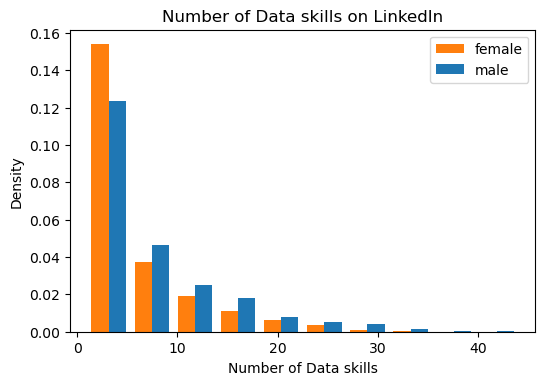

In [65]:
fig, axes = plt.subplots(figsize=(6,4), dpi= 100,)
plt.hist(ai_sk.pivot(columns='gender_recat',values='count'), density=True, color=['#ff7f0e','#1f77b4'], label=['female','male'])
axes.set_title('Number of Data skills on LinkedIn')
axes.legend()
axes.set(xlabel='Number of Data skills', ylabel='Density')

In [66]:
ai_sk.groupby('gender_recat')['count'].describe()

,count,mean,std,min,25%,50%,75%,max
gender_recat,,,,,,,,
female,1365.0,5.550916,5.609593,1.0,2.0,3.0,7.0,33.0
male,12044.0,7.377117,6.968566,1.0,2.0,5.0,10.0,44.0


In [67]:
stats.ttest_ind(ai_sk[ai_sk.gender_recat == 'female']['count'].values,
                         ai_sk[ai_sk.gender_recat == 'male']['count'].values)

Ttest_indResult(statistic=-9.34496773902768, pvalue=1.0624126007515679e-20)

In [68]:
for country in profiles_df.location2.unique():
    print(country, end=": ")
    print(stats.ttest_ind(profiles_df[(profiles_df.gender_recat == 'female') & (profiles_df.location2 == country)].n_skills.values,
                             profiles_df[(profiles_df.gender_recat == 'male') & (profiles_df.location2 == country)].n_skills.values))

Others: Ttest_indResult(statistic=-4.668523794512219, pvalue=3.07952916151125e-06)
Germany: Ttest_indResult(statistic=-2.667730110271268, pvalue=0.007703441398920484)
France: Ttest_indResult(statistic=-3.9091941125840535, pvalue=9.578089846059109e-05)
United kingdom: Ttest_indResult(statistic=-5.039581664216526, pvalue=5.185101096255864e-07)
nan: Ttest_indResult(statistic=nan, pvalue=nan)
United states: Ttest_indResult(statistic=-3.6217904831033128, pvalue=0.00029609535294768645)


# 4. Women are overqualified compared to men for senior and CXO positions (10% gap)

## Women are overqualified compared to men across all industries. However, the achievement gap is higher for more senior ranks (i.e. for CXO roles).

In [69]:
df_cxo = last_role[last_role.seniority3 == 'CXO'].groupby(['industry_group','gender_recat']).max_degree2.value_counts(normalize=True).reset_index(name='count')
df_cxo = df_cxo[df_cxo.max_degree2 == 'post graduate']
#df = df[~df.industry_group.isin(['Arts','Other','Government, NGOs & Legislation','Energy & materials','Education','Academia'])]
df_cxo = df_cxo[df_cxo.industry_group.isin(['Technology/IT','Industrials and manufacturing','Finance','Consumer goods, services and staples'])]
df_cxo['sample'] = 'CXO'

df_all = max_degree_industry[~max_degree_industry.industry_group.isin(['Arts','Other','Government, NGOs & Legislation','Energy & materials','Education','Academia'])].groupby(['industry_group','gender_recat']).max_degree2.value_counts(normalize=True).reset_index(name='count')
df_all = df_all[df_all.max_degree2 == 'post graduate']
df_all = df_all[df_all.industry_group.isin(['Technology/IT','Industrials and manufacturing','Finance','Consumer goods, services and staples'])]
df_all['sample'] = 'All'

df_plot = pd.concat([df_all,df_cxo])


[Text(0.5, 0, '%')]

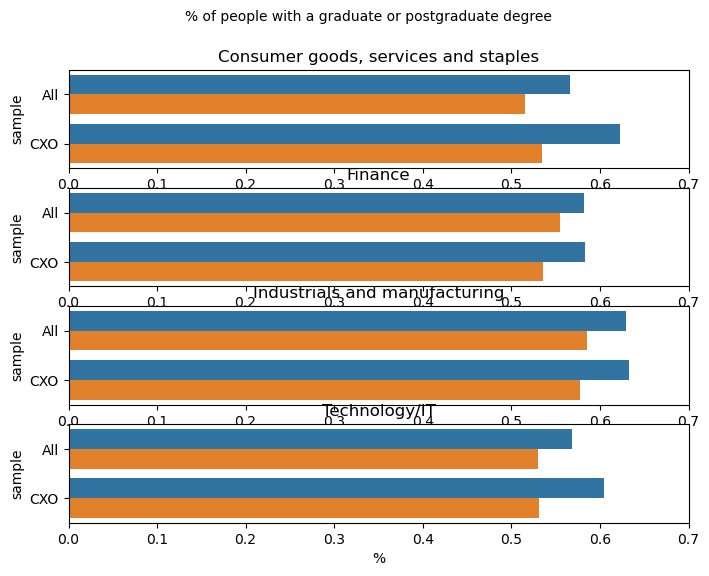

In [70]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8,6), dpi= 100,)

for idx, ind in enumerate(df_plot.industry_group.unique()):
    plot = sns.barplot(y = "sample",       # x variable name
                x = "count",       # y variable name
                hue = "gender_recat",  # group variable name
                data = df_plot[df_plot.industry_group == ind],
                ax=axes[idx]
               )     # dataframe to plot)
    axes[idx].set_title(ind)
    axes[idx].set(xlim=(0, 0.7))
    plot.legend_.remove()
    
fig.suptitle('% of people with a graduate or postgraduate degree', size=10)
axes[-1].set(xlabel='%')

In [71]:
df_plot = df_plot.pivot(index=['industry_group','sample'],columns='gender_recat')['count']
df_plot['gap'] = df_plot.female/df_plot.male
df_plot

gender_recat                                   female      male       gap
industry_group                       sample                              
Consumer goods, services and staples All     0.565714  0.515913  1.096531
                                     CXO     0.622449  0.534143  1.165324
Finance                              All     0.582090  0.555439  1.047980
                                     CXO     0.582781  0.535238  1.088827
Industrials and manufacturing        All     0.629268  0.584860  1.075929
                                     CXO     0.633333  0.577551  1.096584
Technology/IT                        All     0.568182  0.530062  1.071915
                                     CXO     0.605096  0.531682  1.138078

In [72]:
max_degree.max_degree2.value_counts()

post graduate     8798
bachelor          6165
not university     855
Name: max_degree2, dtype: int64

In [73]:
max_degree.max_degree2.value_counts(normalize=True)

post graduate     0.556202
bachelor          0.389746
not university    0.054052
Name: max_degree2, dtype: float64

In [74]:
last_role.seniority2.value_counts()

Senior     10438
Board       5068
Mid         1106
Founder     1006
Junior        31
Name: seniority2, dtype: int64

In [75]:
last_role.seniority2.value_counts(normalize=True)

Senior     0.591422
Board      0.287155
Mid        0.062666
Founder    0.057000
Junior     0.001756
Name: seniority2, dtype: float64